In [1]:
name = "R09725049_吳延東"
timestep = 8

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ntu-homework2-ver2  --force
! unzip training_x_grid.npy.zip
! unzip testing_x_grid.npy.zip

  0% 0.00/137k [00:00<?, ?B/s]
100% 137k/137k [00:00<00:00, 42.2MB/s]
 58% 18.0M/31.1M [00:00<00:00, 45.6MB/s]
100% 31.1M/31.1M [00:00<00:00, 88.8MB/s]
 87% 27.0M/31.1M [00:00<00:00, 56.7MB/s]
100% 31.1M/31.1M [00:00<00:00, 89.2MB/s]
Archive:  training_x_grid.npy.zip
  inflating: training_x_grid.npy     
Archive:  testing_x_grid.npy.zip
  inflating: testing_x_grid.npy      


# Import packages

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from scipy import stats
import time

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

seed = 5566
np.random.seed(seed)

In [4]:
## initailize
training_grid = np.load('training_x_grid.npy')
testing_grid = np.load('testing_x_grid.npy')
print(training_grid.shape, testing_grid.shape)

y = np.load('training_y.npy')
print(y.shape)

(8760, 30, 38, 13) (8760, 30, 38, 13)
(8760, 2)


## 幫 CNN 切訓練、驗證資料集

In [5]:
new_training_grid, val_grid, y_train, y_val = train_test_split(
    training_grid, y, test_size=0.33, random_state=seed)

In [6]:
print(new_training_grid.shape)
print(val_grid.shape)
print(y_train.shape)
print(y_val.shape)

(5869, 30, 38, 13)
(2891, 30, 38, 13)
(5869, 2)
(2891, 2)


(30, 38)


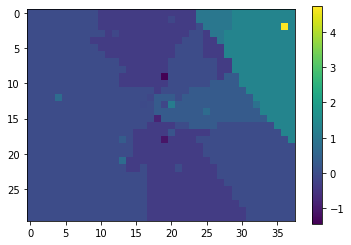

In [7]:
features = -2 #AMB_TEMP, CO, NO, NO2, NOx, O3, PM10, RAINFALL, RH, SO2, THC ,cos_wind, sin_wind
image_shape = new_training_grid[0,:,:,0].shape
print(image_shape)

plt.imshow(new_training_grid[0,:,:,features])
plt.colorbar()
plt.show()

In [8]:
np.c_[new_training_grid, np.expand_dims(np.multiply(new_training_grid[:, :, :, -1], new_training_grid[:, :, :, -2]), axis=3)].shape

(5869, 30, 38, 14)

## 前處理：
因為 cos, sin 的風向向量交乘話會有更詳盡的關係，所以在前處理時會將資料多加一相乘的欄位

In [9]:
def preprocessing(array):
    return np.c_[array, np.expand_dims(np.multiply(array[:, :, :, -1], array[:, :, :, -2]), axis=3)]

In [10]:
preprocessing(new_training_grid).shape

(5869, 30, 38, 14)

# CNN model

In [12]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 38, 14)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(2))

cnn.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Model weights are saved at the end of every epoch, if it's the best seen so far.
# And early stop in 10 epochs

checkpoint_filepath = 'cnn.h5'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]

cnn_history = cnn.fit(
    preprocessing(new_training_grid), y_train, epochs=100, 
    validation_data=(preprocessing(val_grid), y_val), batch_size=256, workers=2, use_multiprocessing=True, 
    callbacks=my_callbacks
    )

# The model weights (that are considered the best) are loaded into the model.
cnn.load_weights(checkpoint_filepath)

Epoch 1/100
23/23 [==============================] - 12s 488ms/step - loss: 1146.9147 - val_loss: 63.5710
Epoch 2/100
23/23 [==============================] - 11s 479ms/step - loss: 59.3647 - val_loss: 52.1851
Epoch 3/100
23/23 [==============================] - 11s 478ms/step - loss: 50.5317 - val_loss: 44.8102
Epoch 4/100
23/23 [==============================] - 11s 478ms/step - loss: 46.4108 - val_loss: 43.2911
Epoch 5/100
23/23 [==============================] - 11s 476ms/step - loss: 43.1712 - val_loss: 41.1451
Epoch 6/100
23/23 [==============================] - 11s 474ms/step - loss: 42.5375 - val_loss: 40.7763
Epoch 7/100
23/23 [==============================] - 11s 474ms/step - loss: 40.6391 - val_loss: 38.9758
Epoch 8/100
23/23 [==============================] - 11s 475ms/step - loss: 39.0699 - val_loss: 40.1236
Epoch 9/100
23/23 [==============================] - 11s 476ms/step - loss: 39.1082 - val_loss: 39.9800
Epoch 10/100
23/23 [==============================] - 11s 476m

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 36, 32)        4064      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 16, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 64)                786496    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

In [14]:
training_pred = cnn.predict(preprocessing(new_training_grid),)
val_pred = cnn.predict(preprocessing(val_grid),)
testing_pred = cnn.predict(preprocessing(testing_grid),)

## 看 CNN 對訓練、驗證資料集的預測結果與真實結果之間的關係

In [15]:
np.corrcoef(training_pred.T[0], y_train.T[0])

array([[1.        , 0.91999675],
       [0.91999675, 1.        ]])

In [16]:
np.corrcoef(training_pred.T[1], y_train.T[1])

array([[1.        , 0.93004634],
       [0.93004634, 1.        ]])

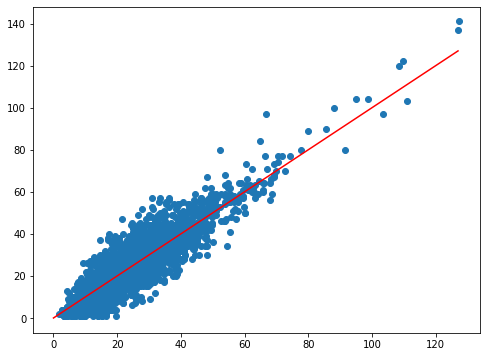

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(val_pred.T[0], y_val.T[0])
plt.plot(np.arange(np.max(val_pred.T[0])), c="r")
plt.show()

## 進入 RNN 前的準備

In [18]:
training_pred = cnn.predict(preprocessing(training_grid),)
testing_pred = cnn.predict(preprocessing(testing_grid),)

In [19]:
y.shape

(8760, 2)

In [20]:
timestep = 8
training_pred_rnn, testing_pred_rnn = ([] for _ in range(2))

for i in range(training_grid.shape[0]-timestep):
    training_pred_rnn.append(training_pred[i:i+timestep])
    testing_pred_rnn.append(testing_pred[i:i+timestep])
training_pred_rnn = np.array(training_pred_rnn)
testing_pred_rnn = np.array(testing_pred_rnn)
training_y_rnn = y[timestep:] #(8760,2) - > (8752,2)
    
print(training_y_rnn.shape, testing_pred_rnn.shape) #(8752,8,2)

(8752, 2) (8752, 8, 2)


In [31]:
np.random.random([32, 10, 8]).astype(np.float32).shape

(32, 10, 8)

# RNN model

In [21]:
rnn = models.Sequential()

rnn.add(layers.Input(shape=(8, 2)))
# Add a LSTM layer with 128 internal units.
rnn.add(layers.SimpleRNN(128, dropout=0.2))
# 運用 layer normalization 來處理資料散佈有極端值的問題
rnn.add(layers.LayerNormalization(axis=-1))
# Add a Dense layer with 2 units.
rnn.add(layers.Dense(2))

In [26]:
# 因為 epoch 跑比較多次，所以 learning rate 調比較小
rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=tf.keras.losses.MeanSquaredError())

# Model weights are saved at the end of every epoch, if it's the best seen so far.
# And early stop in 2 epochs

checkpoint_filepath = 'rnn.h5'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]

# The model weights (that are considered the best) are loaded into the model.
rnn_history = rnn.fit(
    training_pred_rnn, training_y_rnn, epochs=200, validation_split=0.1, batch_size=64, workers=8, use_multiprocessing=True, 
    callbacks=my_callbacks
    )

rnn.load_weights(checkpoint_filepath)

Epoch 1/200
124/124 [==============================] - 2s 8ms/step - loss: 39.8005 - val_loss: 59.2433
Epoch 2/200
124/124 [==============================] - 1s 7ms/step - loss: 38.9627 - val_loss: 55.7053
Epoch 3/200
124/124 [==============================] - 1s 7ms/step - loss: 39.7456 - val_loss: 71.0312
Epoch 4/200
124/124 [==============================] - 1s 7ms/step - loss: 39.5495 - val_loss: 56.3776
Epoch 5/200
124/124 [==============================] - 1s 7ms/step - loss: 38.9573 - val_loss: 61.6783
Epoch 6/200
124/124 [==============================] - 1s 7ms/step - loss: 39.0730 - val_loss: 54.3213
Epoch 7/200
124/124 [==============================] - 1s 7ms/step - loss: 38.7434 - val_loss: 47.7335
Epoch 8/200
124/124 [==============================] - 1s 7ms/step - loss: 38.4015 - val_loss: 63.5289
Epoch 9/200
124/124 [==============================] - 1s 7ms/step - loss: 38.0560 - val_loss: 48.2207
Epoch 10/200
124/124 [==============================] - 1s 7ms/step - los

# Plot the model with validation loss

### CNN model

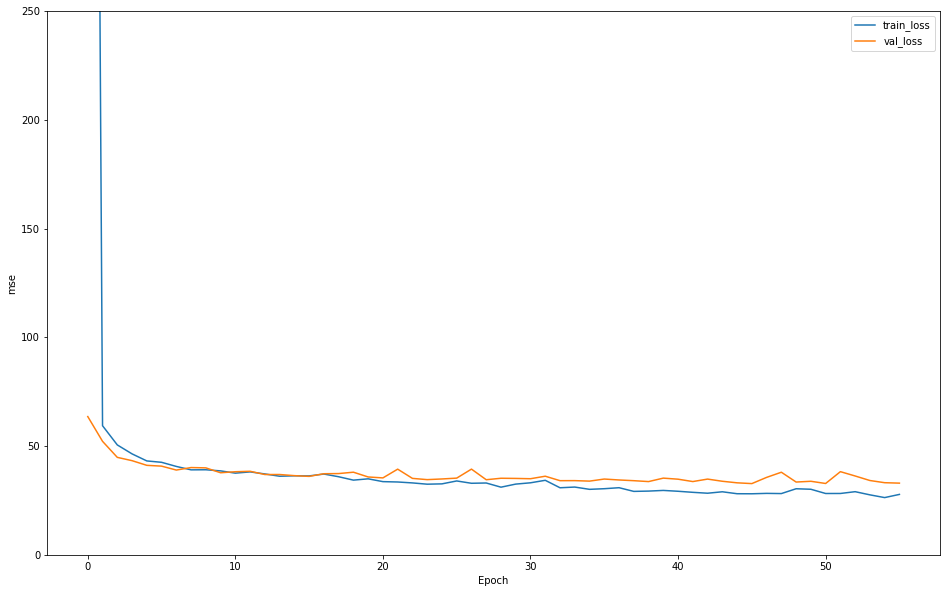

In [27]:
plt.figure(figsize=(16, 10))
plt.plot(cnn_history.history['loss'], label='train_loss')
plt.plot(cnn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.ylim((0, 250))
plt.legend(loc='upper right')

### RNN model

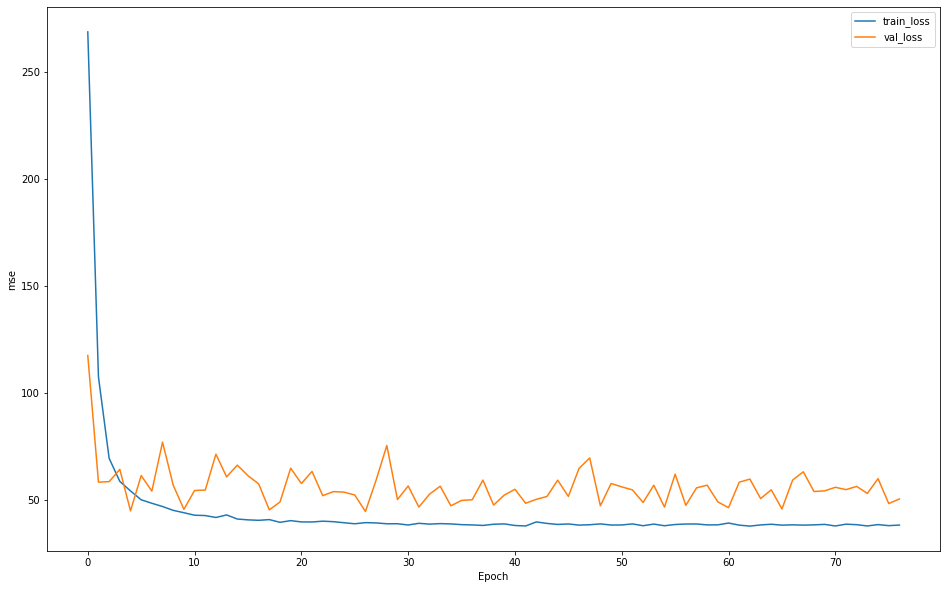

In [24]:
plt.figure(figsize=(16, 10))
plt.plot(rnn_history.history['loss'], label='train_loss')
plt.plot(rnn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(loc='upper right')

# Save results

In [25]:
rnn_testing_pred = rnn.predict(testing_pred_rnn,)
out = pd.DataFrame(rnn_testing_pred, columns=["PM2.5-1", "PM2.5-2"])
out["INDEX"] = list(range(1,len(out)+1))
out = out[["INDEX", "PM2.5-1", "PM2.5-2"]]
out.to_csv("%s.csv" %name, index=False)
out.head()

,INDEX,PM2.5-1,PM2.5-2
0,1,32.901775,29.398956
1,2,32.040127,28.348595
2,3,33.725746,30.020615
3,4,34.174614,29.932777
4,5,36.327492,31.364159
